#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [5]:
!which python
!python --version

/usr/local/bin/python
Python 3.6.9


In [6]:
!pip install html2text

# Install dependencies:

In [ ]:
install_packages = False
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

# Imports

In [7]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [12]:
data_path = './data/comments_climate_change_trump.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [13]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [14]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

In [15]:
data.head()

,id,replyCount,likeCount,publishedAt,authorName,text,authorChannelId,authorChannelUrl,isReply,isReplyTo,isReplyToName
0,UgzwMT8VGhOGEfka8vJ4AaABAg,0.0,0,2020-11-14 17:49:26,Art Lover,He&#39;s so politically correct! What a great man! POS!!!,UCOl3TBZ5zfrNHJ6y0nDK3zw,http://www.youtube.com/channel/UCOl3TBZ5zfrNHJ6y0nDK3zw,0,NaN,NaN
1,UgySDTPTAVvwooP86Lp4AaABAg,0.0,0,2020-11-02 17:01:43,homer j simpson,co2 is life. man can not change the climate. money hoax,UC75kSPu1lVjsr7bgwIllHhQ,http://www.youtube.com/channel/UC75kSPu1lVjsr7bgwIllHhQ,0,NaN,NaN
2,UgzEMSrII-YxJh5bw2t4AaABAg,0.0,0,2020-10-22 14:21:59,Beverly Dwyer,All the president is an advocate for big oil because their filling his freaking pockets..... He’s a waste of very important time . You say climate change to Joe Biden he says jobs jobs and more jobs👍🏻💫,UCRn9qT4uHuA1hVm3aKWfNTA,http://www.youtube.com/channel/UCRn9qT4uHuA1hVm3aKWfNTA,0,NaN,NaN
3,UgzYSV9aVtR7wS7c9nF4AaABAg,0.0,0,2020-10-15 17:49:35,Hobro Club,Where is the whole interview?,UCVej8w_oH1MwECKCw3po8UQ,http://www.youtube.com/channel/UCVej8w_oH1MwECKCw3po8UQ,0,NaN,NaN
4,UgxyLvpaVjw9SxhoY1p4AaABAg,0.0,0,2020-10-12 19:25:59,LUKE EAGLE,Climate change is a scam from Roman Catholic Church and left wing socialist. Mr president tell them you believe in creation so that CC is in GOD&#39;S hand only.,UCOEpSM2pFVDma6mzD7ni-MQ,http://www.youtube.com/channel/UCOEpSM2pFVDma6mzD7ni-MQ,0,NaN,NaN


# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [16]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [17]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 757/757 [00:00<00:00, 5393.83it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [18]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-14 17:49:26,Art Lover,He&#39;s so politically correct! What a great man! POS!!!,0,He's so politically correct! What a great man! POS!!!\n\n
1,2020-11-02 17:01:43,homer j simpson,co2 is life. man can not change the climate. money hoax,0,co2 is life. man can not change the climate. money hoax\n\n
2,2020-10-22 14:21:59,Beverly Dwyer,All the president is an advocate for big oil because their filling his freaking pockets..... He’s a waste of very important time . You say climate change to Joe Biden he says jobs jobs and more jobs👍🏻💫,0,All the president is an advocate for big oil because their filling his\nfreaking pockets..... He’s a waste of very important time . You say climate\nchange to Joe Biden he says jobs jobs and more jobs👍🏻💫\n\n
3,2020-10-15 17:49:35,Hobro Club,Where is the whole interview?,0,Where is the whole interview?\n\n
4,2020-10-12 19:25:59,LUKE EAGLE,Climate change is a scam from Roman Catholic Church and left wing socialist. Mr president tell them you believe in creation so that CC is in GOD&#39;S hand only.,0,Climate change is a scam from Roman Catholic Church and left wing socialist.\nMr president tell them you believe in creation so that CC is in GOD'S hand\nonly.\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [19]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [20]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 The embeddings vector is of fixed length 512


TensorShape([757, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.          0.1494708   0.1671412  ... -0.04761782  0.25915042
   0.3377232 ]
 [ 0.1494708   0.9999999   0.20697746 ...  0.12819368  0.09571084
   0.06458462]
 [ 0.1671412   0.20697746  1.0000006  ...  0.02210272  0.21918434
   0.13197531]
 ...
 [-0.04761782  0.12819368  0.02210272 ...  1.0000001   0.33803537
   0.03947615]
 [ 0.25915042  0.09571084  0.21918434 ...  0.33803537  1.0000001
   0.24737117]
 [ 0.3377232   0.06458462  0.13197531 ...  0.03947615  0.24737117
   1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


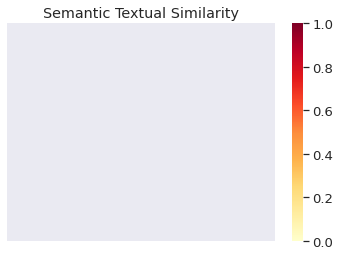

In [22]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [ ]:
comment_index = 527 #324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Print similar comments.

In [39]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Perhaps you could run for president and do it better? LOL. Really. LOL.


Top similar comment 2: I'm sure you could do so much better.


Top similar comment 3: @ what fucking garbage "perhaps you could run for president and do
it better" wow what a piece of shit comment, how stupid do you have to be?
what about if my plummer does a bad job and ruins my toilet, he cant get any
criticism because i dont have his job? what.. the... fuck... this has to be a
joke, it has to be, it's like saying "perhaps you could do better than this
rich guy" it makes zero sense


Top similar comment 4:  wow you are quite the funny character, aren’t you?


Top similar comment 5:  lol ur funny. Love trump


Top similar comment 6:  you better be joking


Top similar comment 7: yep quite. sounds like you nailed it,


Top similar comment 8: hahahaha you wish buddy have fun in your shithole country


Top similar comment 9:  I really hope you’re joking about😂


Top similar comment 10: Anyone